Starting learning rate comparison experiment...
Observing effect of learning rate (α) on winning rate...
This will take several minutes to complete.
Running experiment set 1/5
  Alpha = 0.01
  Alpha = 0.2
  Alpha = 0.5
  Alpha = 0.7
  Alpha = 0.99
  Run 1: α = 0.01 → 0.688 win rate
  Run 1: α = 0.2 → 0.720 win rate
  Run 1: α = 0.5 → 0.764 win rate
  Run 1: α = 0.7 → 0.722 win rate
  Run 1: α = 0.99 → 0.704 win rate
Running experiment set 2/5
  Alpha = 0.01
  Alpha = 0.2
  Alpha = 0.5
  Alpha = 0.7
  Alpha = 0.99
  Run 2: α = 0.01 → 0.682 win rate
  Run 2: α = 0.2 → 0.684 win rate
  Run 2: α = 0.5 → 0.752 win rate
  Run 2: α = 0.7 → 0.748 win rate
  Run 2: α = 0.99 → 0.708 win rate
Running experiment set 3/5
  Alpha = 0.01
  Alpha = 0.2
  Alpha = 0.5
  Alpha = 0.7
  Alpha = 0.99
  Run 3: α = 0.01 → 0.672 win rate
  Run 3: α = 0.2 → 0.724 win rate
  Run 3: α = 0.5 → 0.708 win rate
  Run 3: α = 0.7 → 0.694 win rate
  Run 3: α = 0.99 → 0.708 win rate
Running experiment set 4/5
  Alpha = 0

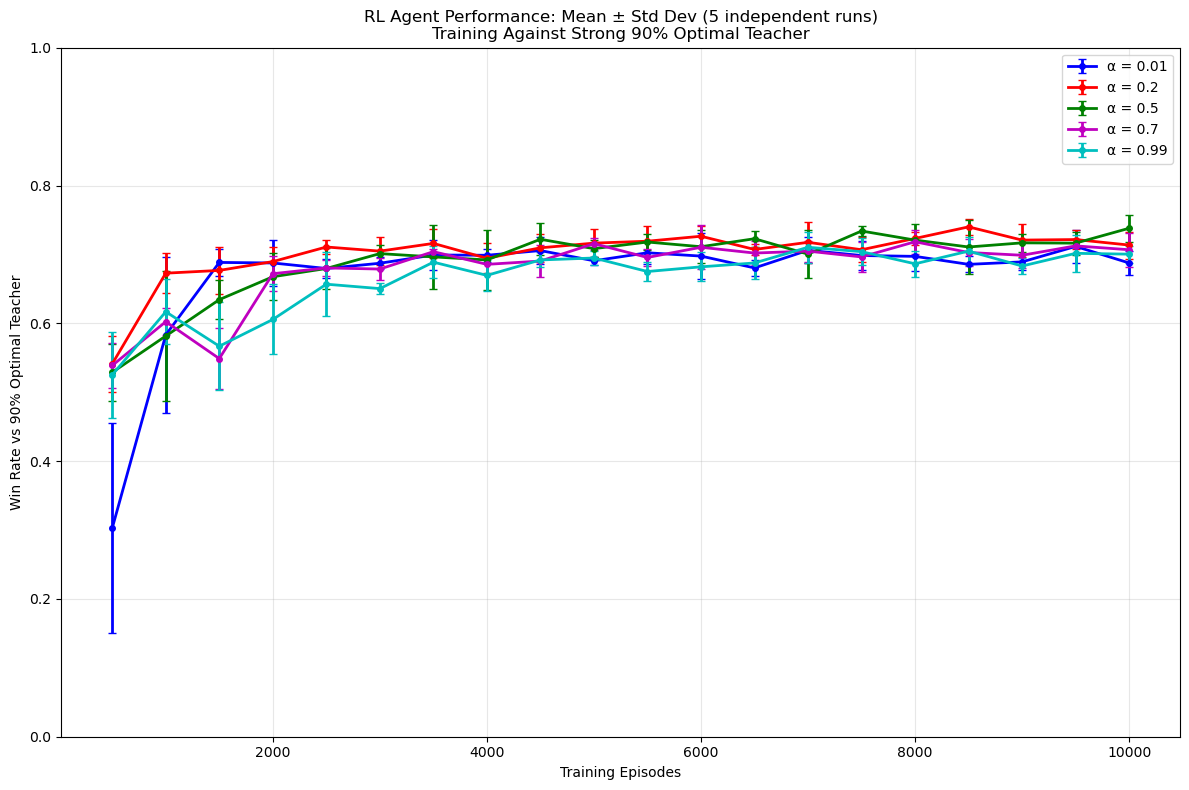

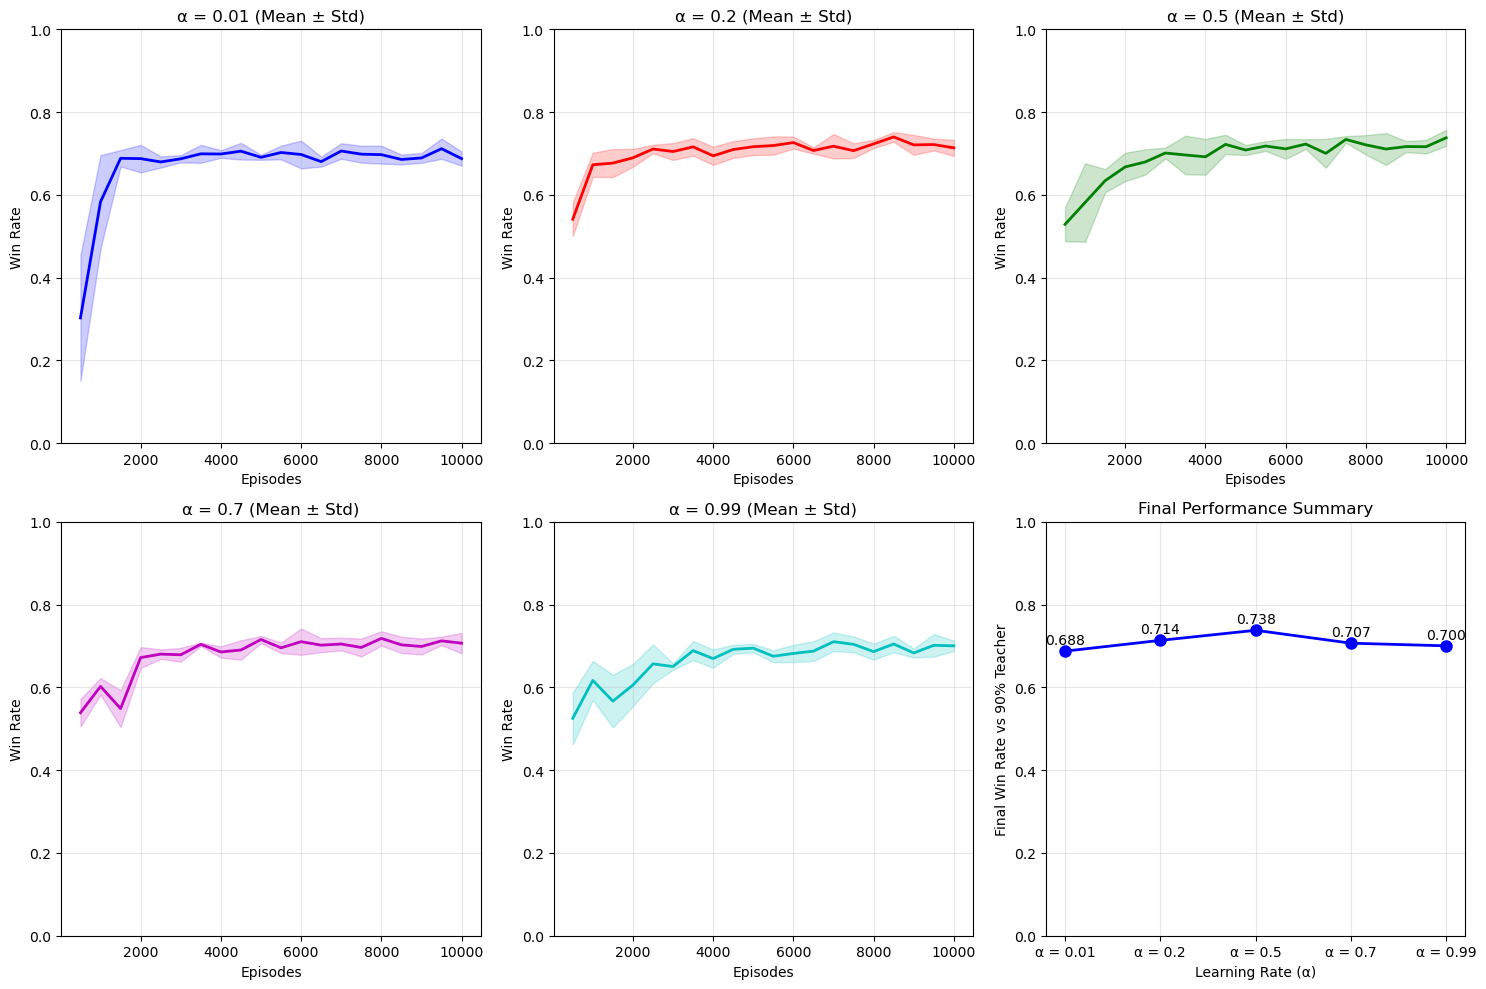


Final Performance Summary:
----------------------------------------------------------------------
α = 0.01: Win = 0.688, Loss = 0.175, Draw = 0.137
α = 0.20: Win = 0.714, Loss = 0.119, Draw = 0.168
α = 0.50: Win = 0.738, Loss = 0.096, Draw = 0.166
α = 0.70: Win = 0.707, Loss = 0.100, Draw = 0.193
α = 0.99: Win = 0.700, Loss = 0.100, Draw = 0.200
\nBest performing agent: α = 0.5 (Win rate: 0.738)


KeyboardInterrupt: Interrupted by user

In [5]:
import random
import csv
import matplotlib.pyplot as plt

# Game constants
EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3

BOARD_FORMAT = "----------------------------\n| {0} | {1} | {2} |\n|--------------------------|\n| {3} | {4} | {5} |\n|--------------------------|\n| {6} | {7} | {8} |\n----------------------------"
NAMES = [' ', 'X', 'O']

def printboard(state):
    cells = []
    for i in range(3):
        for j in range(3):
            cells.append(NAMES[state[i][j]].center(6))
    print(BOARD_FORMAT.format(*cells))

def emptystate():
    return [[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]]

def gameover(state):
    # Check rows
    for i in range(3):
        if state[i][0] != EMPTY and state[i][0] == state[i][1] and state[i][0] == state[i][2]:
            return state[i][0]
    # Check columns
    for i in range(3):
        if state[0][i] != EMPTY and state[0][i] == state[1][i] and state[0][i] == state[2][i]:
            return state[0][i]
    # Check diagonals
    if state[0][0] != EMPTY and state[0][0] == state[1][1] and state[0][0] == state[2][2]:
        return state[0][0]
    if state[0][2] != EMPTY and state[0][2] == state[1][1] and state[0][2] == state[2][0]:
        return state[0][2]
    # Check for draw
    for i in range(3):
        for j in range(3):
            if state[i][j] == EMPTY:
                return EMPTY
    return DRAW

def last_to_act(state):
    countx = 0
    counto = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] == PLAYER_X:
                countx += 1
            elif state[i][j] == PLAYER_O:
                counto += 1
    if countx == counto:
        return PLAYER_O
    if countx == (counto + 1):
        return PLAYER_X
    return -1

def enumstates(state, idx, agent):
    if idx > 8:
        player = last_to_act(state)
        if player == agent.player:
            agent.add(state)
    else:
        winner = gameover(state)
        if winner != EMPTY:
            return
        i = int(idx / 3)
        j = int(idx % 3)
        for val in range(3):
            state[i][j] = val
            enumstates(state, idx+1, agent)

class Agent(object):
    def __init__(self, player, verbose=False, lossval=-1, learning=True, alpha=0.1):
        self.values = {}
        self.player = player
        self.verbose = verbose
        self.lossval = lossval
        self.learning = learning
        self.epsilon = 0.1
        self.alpha = alpha
        self.prevstate = None
        self.prevscore = 0
        self.count = 0
        enumstates(emptystate(), 0, self)

    def episode_over(self, winner):
        self.backup(self.winnerval(winner))
        self.prevstate = None
        self.prevscore = 0

    def action(self, state):
        r = random.random()
        if r < self.epsilon:
            move = self.random(state)
            self.log('>>>>>>> Exploratory action: ' + str(move))
        else:
            move = self.greedy(state)
            self.log('>>>>>>> Best action: ' + str(move))
        state[move[0]][move[1]] = self.player
        self.prevstate = self.statetuple(state)
        self.prevscore = self.lookup(state)
        state[move[0]][move[1]] = EMPTY
        return move

    def random(self, state):
        available = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    available.append((i,j))
        return random.choice(available)

    def greedy(self, state):
        maxval = -50000
        maxmove = None
        if self.verbose:
            cells = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup(state)
                    state[i][j] = EMPTY
                    if val > maxval:
                        maxval = val
                        maxmove = (i, j)
                    if self.verbose:
                        cells.append('{0:.3f}'.format(val).center(6))
                elif self.verbose:
                    cells.append(NAMES[state[i][j]].center(6))
        if self.verbose:
            print(BOARD_FORMAT.format(*cells))
        self.backup(maxval)
        return maxmove

    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        elif winner == DRAW:
            return 0
        else:
            return self.lossval

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

    def log(self, s):
        if self.verbose:
            print(s)

class Human(object):
    def __init__(self, player):
        self.player = player

    def action(self, state):
        printboard(state)
        while True:
            try:
                action = input('Your move? i.e. x,y : ')
                row, col = int(action.split(',')[0]), int(action.split(',')[1])
                if 0 <= row <= 2 and 0 <= col <= 2:
                    if state[row][col] == EMPTY:
                        return (row, col)
                    else:
                        print("That position is already occupied! Please choose an empty square.")
                else:
                    print("Please enter coordinates between 0-2 (e.g., 1,1)")
            except (ValueError, IndexError):
                print("Invalid input! Please enter in format: x,y (e.g., 1,1)")

    def episode_over(self, winner):
        if winner == DRAW:
            print('Game over! It was a draw.')
        else:
            print('Game over! Winner: Player {0}'.format(winner))

class Teacher:
    def __init__(self, level=0.9, player=PLAYER_O, learning=True, alpha=0.99):
        self.ability_level = level
        self.player = player
        # Add RL learning capabilities to teacher
        self.learning = learning
        self.alpha = alpha
        self.values = {}
        self.prevstate = None
        self.prevscore = 0
        self.lossval = -1
        # Initialize value function for all possible states
        enumstates(emptystate(), 0, self)

    def convert_board(self, state):
        """Convert from numeric board to string board for teacher logic"""
        board = []
        for i in range(3):
            row = []
            for j in range(3):
                if state[i][j] == EMPTY:
                    row.append('-')
                elif state[i][j] == PLAYER_X:
                    row.append('X')
                else:
                    row.append('O')
            board.append(row)
        return board

    def win(self, board, key='O'):
        """If we have two in a row and the 3rd is available, take it."""
        # Check for diagonal wins
        a = [board[0][0], board[1][1], board[2][2]]
        b = [board[0][2], board[1][1], board[2][0]]
        if a.count('-') == 1 and a.count(key) == 2:
            ind = a.index('-')
            return ind, ind
        elif b.count('-') == 1 and b.count(key) == 2:
            ind = b.index('-')
            if ind == 0:
                return 0, 2
            elif ind == 1:
                return 1, 1
            else:
                return 2, 0
        # Now check for 2 in a row/column + empty 3rd
        for i in range(3):
            c = [board[0][i], board[1][i], board[2][i]]
            d = [board[i][0], board[i][1], board[i][2]]
            if c.count('-') == 1 and c.count(key) == 2:
                ind = c.index('-')
                return ind, i
            elif d.count('-') == 1 and d.count(key) == 2:
                ind = d.index('-')
                return i, ind
        return None

    def blockWin(self, board):
        """Block the opponent if she has a win available."""
        return self.win(board, key='X')

    def fork(self, board):
        """Create a fork opportunity such that we have 2 threats to win."""
        # Check all adjacent side middles
        if board[1][0] == 'O' and board[0][1] == 'O':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'O' and board[2][1] == 'O':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'O' and board[1][2] == 'O':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'O' and board[0][1] == 'O':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        # Check all cross corners
        elif board[0][0] == 'O' and board[2][2] == 'O':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'O' and board[0][2] == 'O':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def blockFork(self, board):
        """Block the opponents fork if she has one available."""
        corners = [board[0][0], board[2][0], board[0][2], board[2][2]]
        # Check all adjacent side middles
        if board[1][0] == 'X' and board[0][1] == 'X':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'X' and board[2][1] == 'X':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'X' and board[1][2] == 'X':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'X' and board[0][1] == 'X':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        # Check all cross corners (first check for double fork opp using the corners array)
        elif corners.count('-') == 1 and corners.count('X') == 2:
            return 1, 2
        elif board[0][0] == 'X' and board[2][2] == 'X':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'X' and board[0][2] == 'X':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def center(self, board):
        """Pick the center if it is available."""
        if board[1][1] == '-':
            return 1, 1
        return None

    def corner(self, board):
        """Pick a corner move."""
        # Pick opposite corner of opponent if available
        if board[0][0] == 'X' and board[2][2] == '-':
            return 2, 2
        elif board[2][0] == 'X' and board[0][2] == '-':
            return 0, 2
        elif board[0][2] == 'X' and board[2][0] == '-':
            return 2, 0
        elif board[2][2] == 'X' and board[0][0] == '-':
            return 0, 0
        # Pick any corner if no opposites are available
        elif board[0][0] == '-':
            return 0, 0
        elif board[2][0] == '-':
            return 2, 0
        elif board[0][2] == '-':
            return 0, 2
        elif board[2][2] == '-':
            return 2, 2
        return None

    def sideEmpty(self, board):
        """Pick an empty side."""
        if board[1][0] == '-':
            return 1, 0
        elif board[2][1] == '-':
            return 2, 1
        elif board[1][2] == '-':
            return 1, 2
        elif board[0][1] == '-':
            return 0, 1
        return None

    def randomMove(self, board):
        """Choose a random move from the available options."""
        possibles = []
        for i in range(3):
            for j in range(3):
                if board[i][j] == '-':
                    possibles += [(i, j)]
        return possibles[random.randint(0, len(possibles)-1)]

    def makeMove(self, board):
        """
        Teacher goes through a hierarchy of moves, making the best move that
        is currently available each time. A tuple is returned that represents
        (row, col).
        """
        # Choose randomly with some probability so that the teacher does not always win
        if random.random() > self.ability_level:
            return self.randomMove(board)
        # Follow optimal strategy
        a = self.win(board)
        if a is not None:
            return a
        a = self.blockWin(board)
        if a is not None:
            return a
        a = self.fork(board)
        if a is not None:
            return a
        a = self.blockFork(board)
        if a is not None:
            return a
        a = self.center(board)
        if a is not None:
            return a
        a = self.corner(board)
        if a is not None:
            return a
        a = self.sideEmpty(board)
        if a is not None:
            return a
        return self.randomMove(board)

    def action(self, state):
        """Convert state and make move using teacher logic with RL learning"""
        board = self.convert_board(state)
        move = self.makeMove(board)
        
        # Add RL learning like Agent class
        if self.learning:
            state[move[0]][move[1]] = self.player
            self.prevstate = self.statetuple(state)
            self.prevscore = self.lookup(state)
            state[move[0]][move[1]] = EMPTY
        
        return move

    def episode_over(self, winner):
        """Learn from game outcome like Agent class"""
        if self.learning:
            self.backup(self.winnerval(winner))
            self.prevstate = None
            self.prevscore = 0

    # Add RL learning methods to Teacher (same as Agent)
    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        elif winner == DRAW:
            return 0
        else:
            return self.lossval

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

def play(agent1, agent2):
    """Play a single game between two agents"""
    state = emptystate()
    for i in range(9):
        if i % 2 == 0:
            move = agent1.action(state)
        else:
            move = agent2.action(state)
        state[move[0]][move[1]] = (i % 2) + 1
        winner = gameover(state)
        if winner != EMPTY:
            return winner
    return winner

def measure_performance_vs_opponent(agent, opponent, games=100):
    """Measure agent performance against any opponent (no learning)"""
    original_epsilon = agent.epsilon
    original_learning = agent.learning
    agent.epsilon = 0  # Pure greedy
    agent.learning = False
    
    wins = 0
    losses = 0
    draws = 0
    
    for _ in range(games):
        winner = play(agent, opponent)
        if winner == agent.player:
            wins += 1
        elif winner == opponent.player:
            losses += 1
        else:
            draws += 1
    
    # Restore original settings
    agent.epsilon = original_epsilon
    agent.learning = original_learning
    
    return wins / games, losses / games, draws / games

def run_multiple_experiments(alpha_values, total_episodes=5000, eval_interval=100, num_runs=5):
    """Run multiple independent experiments and average results"""
    all_runs = {}
    individual_results = {}
    
    for run in range(num_runs):
        print(f"Running experiment set {run + 1}/{num_runs}")
        # Use None for random seed each run, or use time-based seed for true randomness
        results, _ = run_single_experiment(alpha_values, total_episodes, eval_interval, None)
        all_runs[run] = results
        
        # Store individual run results
        for alpha in alpha_values:
            if alpha not in individual_results:
                individual_results[alpha] = []
            final_win_rate = results[alpha]['win_rates'][-1]
            individual_results[alpha].append(final_win_rate)
            print(f"  Run {run + 1}: α = {alpha} → {final_win_rate:.3f} win rate")
    
    # Average across runs
    averaged_results = {}
    trained_agents = {}
    
    for alpha in alpha_values:
        # Collect all episodes and rates from all runs
        all_episodes = all_runs[0][alpha]['episodes']
        all_win_rates = []
        all_loss_rates = []
        all_draw_rates = []
        
        for run in range(num_runs):
            all_win_rates.append(all_runs[run][alpha]['win_rates'])
            all_loss_rates.append(all_runs[run][alpha]['loss_rates'])
            all_draw_rates.append(all_runs[run][alpha]['draw_rates'])
        
        # Calculate mean and std for each evaluation point
        import numpy as np
        mean_win_rates = np.mean(all_win_rates, axis=0)
        std_win_rates = np.std(all_win_rates, axis=0)
        mean_loss_rates = np.mean(all_loss_rates, axis=0)
        std_loss_rates = np.std(all_loss_rates, axis=0)
        mean_draw_rates = np.mean(all_draw_rates, axis=0)
        std_draw_rates = np.std(all_draw_rates, axis=0)
        
        averaged_results[alpha] = {
            'episodes': all_episodes,
            'win_rates': mean_win_rates,
            'win_std': std_win_rates,
            'loss_rates': mean_loss_rates,
            'loss_std': std_loss_rates,
            'draw_rates': mean_draw_rates,
            'draw_std': std_draw_rates
        }
        
        # Train one final agent for human play
        print(f"Training final agent for human play with alpha = {alpha}")
        agent = Agent(PLAYER_X, alpha=alpha, lossval=-1)
        teacher = Teacher(level=0.9, player=PLAYER_O, learning=False)  # 90% optimal for stronger training
        for _ in range(total_episodes):
            winner = play(agent, teacher)
            agent.episode_over(winner)
        trained_agents[alpha] = agent
    
    # Print detailed results summary
    print("\n" + "="*80)
    print("DETAILED RESULTS SUMMARY")
    print("="*80)
    
    for alpha in alpha_values:
        runs = individual_results[alpha]
        mean_val = np.mean(runs)
        std_val = np.std(runs)
        print(f"\nα = {alpha}:")
        print(f"  Individual runs: {[f'{x:.3f}' for x in runs]}")
        print(f"  Mean: {mean_val:.3f}")
        print(f"  Std Dev: {std_val:.3f}")
        print(f"  Range: {min(runs):.3f} - {max(runs):.3f}")
    
    return averaged_results, trained_agents

def run_single_experiment(alpha_values, total_episodes=5000, eval_interval=100, seed=None):
    """Run single learning experiment with optional random seed"""
    if seed is not None:
        random.seed(seed)
    
    results = {}
    trained_agents = {}
    
    for alpha in alpha_values:
        print(f"  Alpha = {alpha}")
        
        # Create agent and stronger teacher for challenging training
        agent = Agent(PLAYER_X, alpha=alpha, lossval=-1)
        teacher = Teacher(level=0.9, player=PLAYER_O, learning=False)  # 90% optimal = stronger opponent
        
        # Track training results
        training_results = []
        episode_points = []
        win_rates = []
        loss_rates = []
        draw_rates = []
        
        for episode in range(1, total_episodes + 1):
            winner = play(agent, teacher)
            agent.episode_over(winner)
            
            if winner == agent.player:
                training_results.append('win')
            elif winner == teacher.player:
                training_results.append('loss')
            else:
                training_results.append('draw')
            
            if episode % eval_interval == 0:
                recent_results = training_results[-eval_interval:]
                wins = recent_results.count('win')
                losses = recent_results.count('loss')
                draws = recent_results.count('draw')
                
                win_rate = wins / len(recent_results)
                loss_rate = losses / len(recent_results)
                draw_rate = draws / len(recent_results)
                
                episode_points.append(episode)
                win_rates.append(win_rate)
                loss_rates.append(loss_rate)
                draw_rates.append(draw_rate)
        
        results[alpha] = {
            'episodes': episode_points,
            'win_rates': win_rates,
            'loss_rates': loss_rates,
            'draw_rates': draw_rates
        }
        
        trained_agents[alpha] = agent
    
    return results, trained_agents

def plot_learning_curves_with_error_bars(results):
    """Plot learning curves with error bars from multiple runs"""
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    
    # Create two separate figures for clarity
    # Figure 1: Main comparison with error bars
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.errorbar(data['episodes'], data['win_rates'], 
                    yerr=data['win_std'],
                    color=colors[i % len(colors)], 
                    marker='o', 
                    label=f'α = {alpha}',
                    linewidth=2,
                    markersize=4,
                    capsize=3)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Win Rate vs 90% Optimal Teacher')
    plt.title('RL Agent Performance: Mean ± Std Dev (5 independent runs)\nTraining Against Strong 90% Optimal Teacher')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Figure 2: Individual alpha plots with final performance summary
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Individual alpha plots
    for i, (alpha, data) in enumerate(results.items()):
        if i < 5:  # First 5 subplots for individual alphas
            axes[i].plot(data['episodes'], data['win_rates'], 
                        color=colors[i % len(colors)], 
                        linewidth=2)
            axes[i].fill_between(data['episodes'], 
                                data['win_rates'] - data['win_std'],
                                data['win_rates'] + data['win_std'],
                                color=colors[i % len(colors)], alpha=0.2)
            axes[i].set_xlabel('Episodes')
            axes[i].set_ylabel('Win Rate')
            axes[i].set_title(f'α = {alpha} (Mean ± Std)')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim(0, 1)
    
    # Final performance summary in the 6th subplot
    alphas = list(results.keys())
    final_win_rates = [results[alpha]['win_rates'][-1] for alpha in alphas]
    
    axes[5].plot(range(len(alphas)), final_win_rates, 
                 marker='o', 
                 linewidth=2,
                 markersize=8,
                 color='blue')
    
    # Add value labels on points
    for i, win_rate in enumerate(final_win_rates):
        axes[5].text(i, win_rate + 0.01,
                    f'{win_rate:.3f}',
                    ha='center', va='bottom', fontsize=10)
    
    axes[5].set_xlabel('Learning Rate (α)')
    axes[5].set_ylabel('Final Win Rate vs 90% Teacher')
    axes[5].set_title('Final Performance Summary')
    axes[5].set_xticks(range(len(alphas)))
    axes[5].set_xticklabels([f'α = {alpha}' for alpha in alphas])
    axes[5].set_ylim(0, 1)
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()

def plot_final_performance_summary(results):
    """Plot final performance summary as bar chart"""
    plt.figure(figsize=(10, 6))
    
    alphas = list(results.keys())
    final_win_rates = [results[alpha]['win_rates'][-1] for alpha in alphas]
    final_win_stds = [results[alpha]['win_std'][-1] for alpha in alphas]
    
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    
    plt.plot(range(len(alphas)), final_win_rates, 
             marker='o', 
             linewidth=2,
             markersize=8,
             color='blue')
    
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Final Win Rate vs 30% Optimal Teacher')
    plt.title('Final Performance Summary After 10,000 Training Episodes\n(Mean ± Std Dev from 5 independent runs)')
    plt.xticks(range(len(alphas)), [f'α = {alpha}' for alpha in alphas])
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on points
    for i, win_rate in enumerate(final_win_rates):
        plt.text(i, win_rate + 0.01,
                f'{win_rate:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()

def plot_performance_breakdown(results):
    """Plot win/loss/draw rates separately for different alpha values as individual graphs"""
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    
    # Plot win rates
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.plot(data['episodes'], data['win_rates'], 
                color=colors[i % len(colors)], 
                marker='o', 
                label=f'α = {alpha}',
                linewidth=2,
                markersize=4)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Win Rate')
    plt.title('Win Rate vs Random Agent over Training Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(100, max([max(data['episodes']) for data in results.values()]))
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Plot loss rates
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.plot(data['episodes'], data['loss_rates'], 
                color=colors[i % len(colors)], 
                marker='s', 
                label=f'α = {alpha}',
                linewidth=2,
                markersize=4)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Loss Rate')
    plt.title('Loss Rate vs Random Agent over Training Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(100, max([max(data['episodes']) for data in results.values()]))
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Plot draw rates
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.plot(data['episodes'], data['draw_rates'], 
                color=colors[i % len(colors)], 
                marker='^', 
                label=f'α = {alpha}',
                linewidth=2,
                markersize=4)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Draw Rate')
    plt.title('Draw Rate vs Random Agent over Training Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(100, max([max(data['episodes']) for data in results.values()]))
    plt.ylim(0, 1)
    plt.tight_layout()

def plot_individual_alpha_performance(results):
    """Plot all alpha values and summary in one landscape figure"""
    alpha_values = list(results.keys())
    
    # Create landscape figure with subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('RL Agent Performance by Learning Rate (α)\nWinning rate per 500 episodes (10,000 total episodes) vs 90% Optimal Teacher', fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Plot individual alpha performance in first 5 subplots
    for i, (alpha, data) in enumerate(results.items()):
        ax = axes[i]
        
        ax.plot(data['episodes'], data['win_rates'], 
                color='red', linewidth=2, label='Win Rate')
        ax.plot(data['episodes'], data['loss_rates'], 
                color='blue', linewidth=2, label='Loss Rate')
        ax.plot(data['episodes'], data['draw_rates'], 
                color='green', linewidth=2, label='Draw Rate')
        
        ax.set_xlabel('Training Episodes')
        ax.set_ylabel('Rate')
        ax.set_title(f'α = {alpha}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(500, max(data['episodes']))
        ax.set_ylim(0, 1)
    
    # Add final performance comparison in the 6th subplot
    ax_final = axes[5]
    
    # Extract final performance data
    final_win_rates = [results[alpha]['win_rates'][-1] for alpha in alpha_values]
    final_loss_rates = [results[alpha]['loss_rates'][-1] for alpha in alpha_values]
    final_draw_rates = [results[alpha]['draw_rates'][-1] for alpha in alpha_values]
    
    ax_final.plot(alpha_values, final_win_rates, marker='o', linewidth=2, markersize=8, label='Win Rate', color='red')
    ax_final.plot(alpha_values, final_loss_rates, marker='s', linewidth=2, markersize=8, label='Loss Rate', color='blue')
    ax_final.plot(alpha_values, final_draw_rates, marker='^', linewidth=2, markersize=8, label='Draw Rate', color='green')
    
    # Add value labels on points
    for i, alpha in enumerate(alpha_values):
        ax_final.annotate(f'{final_win_rates[i]:.2f}', (alpha, final_win_rates[i]), 
                         textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    ax_final.set_xlabel('Learning Rate (α)')
    ax_final.set_ylabel('Final Rate')
    ax_final.set_title('Final Performance Summary')
    ax_final.legend()
    ax_final.grid(True, alpha=0.3)
    ax_final.set_ylim(0, 1)
    ax_final.set_xlim(min(alpha_values) - 0.05, max(alpha_values) + 0.05)
    
    plt.tight_layout()
    plt.savefig('all_alpha_performance_complete.png', dpi=300, bbox_inches='tight')
    print("Complete performance analysis saved to: all_alpha_performance_complete.png")

def plot_final_performance_by_alpha(results):
    """Plot final win/loss/draw rates for each alpha value as line chart"""
    alpha_values = list(results.keys())
    win_rates = [results[alpha]['win_rates'][-1] for alpha in alpha_values]
    loss_rates = [results[alpha]['loss_rates'][-1] for alpha in alpha_values]
    draw_rates = [results[alpha]['draw_rates'][-1] for alpha in alpha_values]
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(alpha_values, win_rates, marker='o', linewidth=2, markersize=8, label='Win Rate', color='green')
    plt.plot(alpha_values, loss_rates, marker='s', linewidth=2, markersize=8, label='Loss Rate', color='red')
    plt.plot(alpha_values, draw_rates, marker='^', linewidth=2, markersize=8, label='Draw Rate', color='blue')
    
    # Add value labels on points
    for i, alpha in enumerate(alpha_values):
        plt.annotate(f'{win_rates[i]:.3f}', (alpha, win_rates[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f'{loss_rates[i]:.3f}', (alpha, loss_rates[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f'{draw_rates[i]:.3f}', (alpha, draw_rates[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Rate')
    plt.title('Final Performance by Learning Rate\n(After 10000 Training Episodes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.xlim(min(alpha_values) - 0.05, max(alpha_values) + 0.05)
    
    plt.tight_layout()
    plt.savefig('final_performance_by_alpha.png', dpi=300, bbox_inches='tight')
    print("Final performance comparison saved to: final_performance_by_alpha.png")

def play_human_vs_agent(agent):
    """Allow human to play against the trained agent with value visualization"""
    print("\n" + "="*50)
    print("PLAY AGAINST THE TRAINED AGENT!")
    print("="*50)
    print("Enter your moves as x,y coordinates (0,1,2)")
    print("Example: 1,1 for center, 0,0 for top-left")
    print("Values shown are agent's learned position evaluations")
    print("="*50)
    
    # Set agent to pure greedy and verbose
    agent.epsilon = 0
    agent.learning = False
    agent.verbose = True  # Enable value display
    
    human = Human(PLAYER_O)
    
    while True:
        print(f"\nStarting new game! Agent is X, You are O")
        winner = play(agent, human)
        
        if winner == PLAYER_X:
            print("Agent wins! Better luck next time.")
        elif winner == PLAYER_O:
            print("Congratulations! You won!")
        else:
            print("It's a draw!")
        
        play_again = input("\nWant to play again? (y/n): ").lower().strip()
        if play_again != 'y' and play_again != 'yes':
            break
    
    print("Thanks for playing!")

if __name__ == "__main__":
    # Test different learning rates - Report requirement
    alpha_values = [0.01, 0.2, 0.5, 0.7, 0.99]

    print("Starting learning rate comparison experiment...")
    print("Observing effect of learning rate (α) on winning rate...")
    print("This will take several minutes to complete.")
    
    # Run multiple experiments with averaging (5 runs for statistical reliability)
    results, trained_agents = run_multiple_experiments(alpha_values, total_episodes=10000, eval_interval=500, num_runs=5)
    
    # Plot results with error bars showing variability
    plot_learning_curves_with_error_bars(results)
    
    # Show all plots at once
    plt.show()
    
    # Save detailed results to CSV
    with open('learning_rate_results.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        
        # Write header
        header = ['Episode']
        for alpha in alpha_values:
            header.extend([f'Alpha_{alpha}_WinRate', f'Alpha_{alpha}_LossRate', f'Alpha_{alpha}_DrawRate'])
        writer.writerow(header)
        
        # Write data
        max_episodes = max(len(data['episodes']) for data in results.values())
        for i in range(max_episodes):
            row = []
            episode = None
            for alpha in alpha_values:
                if i < len(results[alpha]['episodes']):
                    if episode is None:
                        episode = results[alpha]['episodes'][i]
                    row.extend([results[alpha]['win_rates'][i], 
                               results[alpha]['loss_rates'][i], 
                               results[alpha]['draw_rates'][i]])
                else:
                    row.extend(['', '', ''])
            if episode is not None:
                writer.writerow([episode] + row)
    
    # print("Detailed results saved to: learning_rate_results.csv")
    
    # Print final performance summary
    print("\nFinal Performance Summary:")
    print("-" * 70)
    for alpha in alpha_values:
        final_win_rate = results[alpha]['win_rates'][-1]
        final_loss_rate = results[alpha]['loss_rates'][-1]
        final_draw_rate = results[alpha]['draw_rates'][-1]
        print(f"α = {alpha:4.2f}: Win = {final_win_rate:.3f}, Loss = {final_loss_rate:.3f}, Draw = {final_draw_rate:.3f}")
    
    # Ask user if they want to play against the best performing agent
    best_alpha = max(alpha_values, key=lambda a: results[a]['win_rates'][-1])
    print(f"\\nBest performing agent: α = {best_alpha} (Win rate: {results[best_alpha]['win_rates'][-1]:.3f})")
    
    play_choice = input("\\nWould you like to play against an opponent? (y/n): ").lower().strip()
    if play_choice == 'y' or play_choice == 'yes':
        opponent_choice = input("Choose opponent: (1) Trained RL Agent (2) Optimal Teacher: ").strip()
        
        if opponent_choice == "2":
            # Play against the optimal teacher
            print("Setting up optimal teacher opponent...")
            teacher_opponent = Teacher(level=1.0, player=PLAYER_O)  # 100% optimal
            play_human_vs_agent(teacher_opponent)
        else:
            # Let user choose alpha value from the experiment
            print("\\nChoose alpha value for the RL agent:")
            print("Available alpha values from experiment:", alpha_values)
            while True:
                try:
                    chosen_alpha = float(input("Enter alpha value: "))
                    if chosen_alpha in alpha_values:
                        break
                    else:
                        print(f"Please choose from: {alpha_values}")
                except ValueError:
                    print("Please enter a valid number.")
            
            # Reuse the already trained agent from the experiment
            print(f"Using already trained RL agent with α={chosen_alpha}...")
            human_play_agent = trained_agents[chosen_alpha]
            
            # Keep agent as PLAYER_X (same as training) to preserve learned values
            
            print(f"Agent ready for human play (already trained for {10000} episodes)!")
            play_human_vs_agent(human_play_agent)

Starting learning rate comparison experiment...
Observing effect of learning rate (α) on winning rate...
This will take several minutes to complete.
Running experiment set 1/5
  Alpha = 0.01
  Alpha = 0.2
  Alpha = 0.5
  Alpha = 0.7
  Alpha = 0.99
  Run 1: α = 0.01 → 0.764 win rate
  Run 1: α = 0.2 → 0.868 win rate
  Run 1: α = 0.5 → 0.860 win rate
  Run 1: α = 0.7 → 0.860 win rate
  Run 1: α = 0.99 → 0.836 win rate
Running experiment set 2/5
  Alpha = 0.01
  Alpha = 0.2
  Alpha = 0.5
  Alpha = 0.7
  Alpha = 0.99
  Run 2: α = 0.01 → 0.820 win rate
  Run 2: α = 0.2 → 0.844 win rate
  Run 2: α = 0.5 → 0.860 win rate
  Run 2: α = 0.7 → 0.810 win rate
  Run 2: α = 0.99 → 0.862 win rate
Running experiment set 3/5
  Alpha = 0.01
  Alpha = 0.2
  Alpha = 0.5
  Alpha = 0.7
  Alpha = 0.99
  Run 3: α = 0.01 → 0.852 win rate
  Run 3: α = 0.2 → 0.856 win rate
  Run 3: α = 0.5 → 0.862 win rate
  Run 3: α = 0.7 → 0.842 win rate
  Run 3: α = 0.99 → 0.798 win rate
Running experiment set 4/5
  Alpha = 0

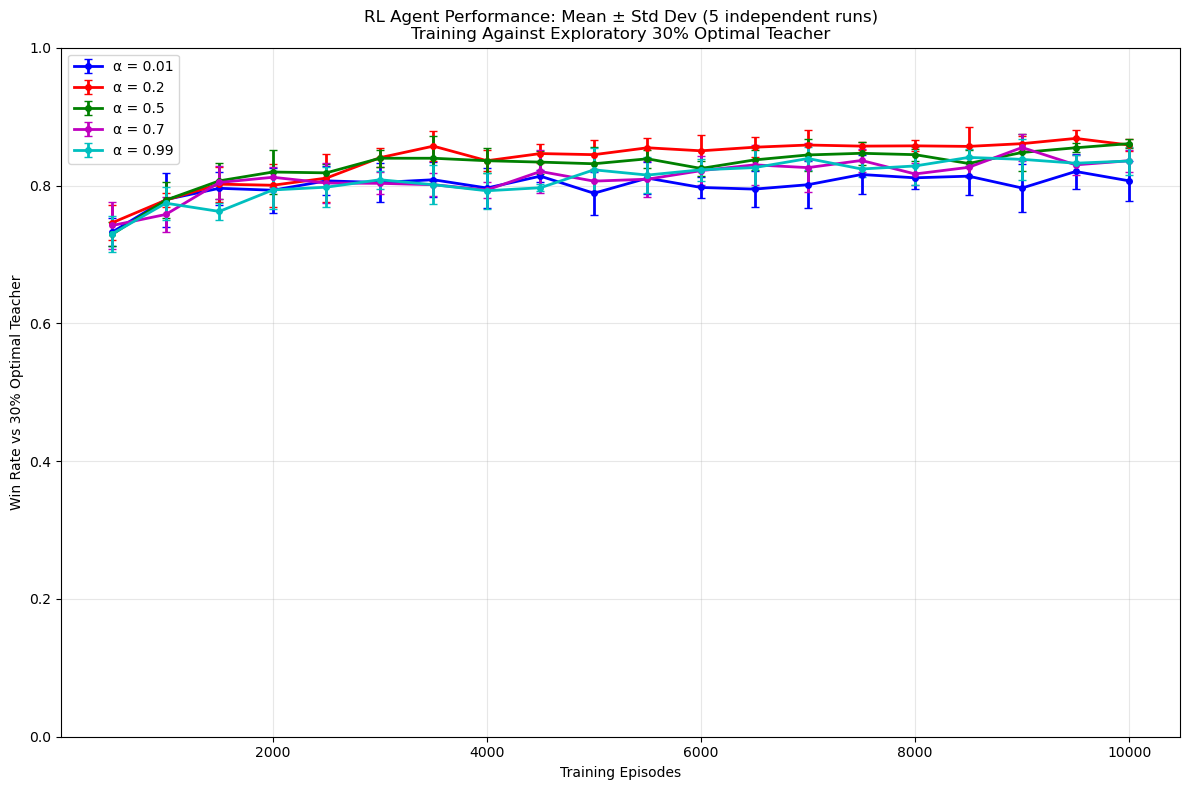

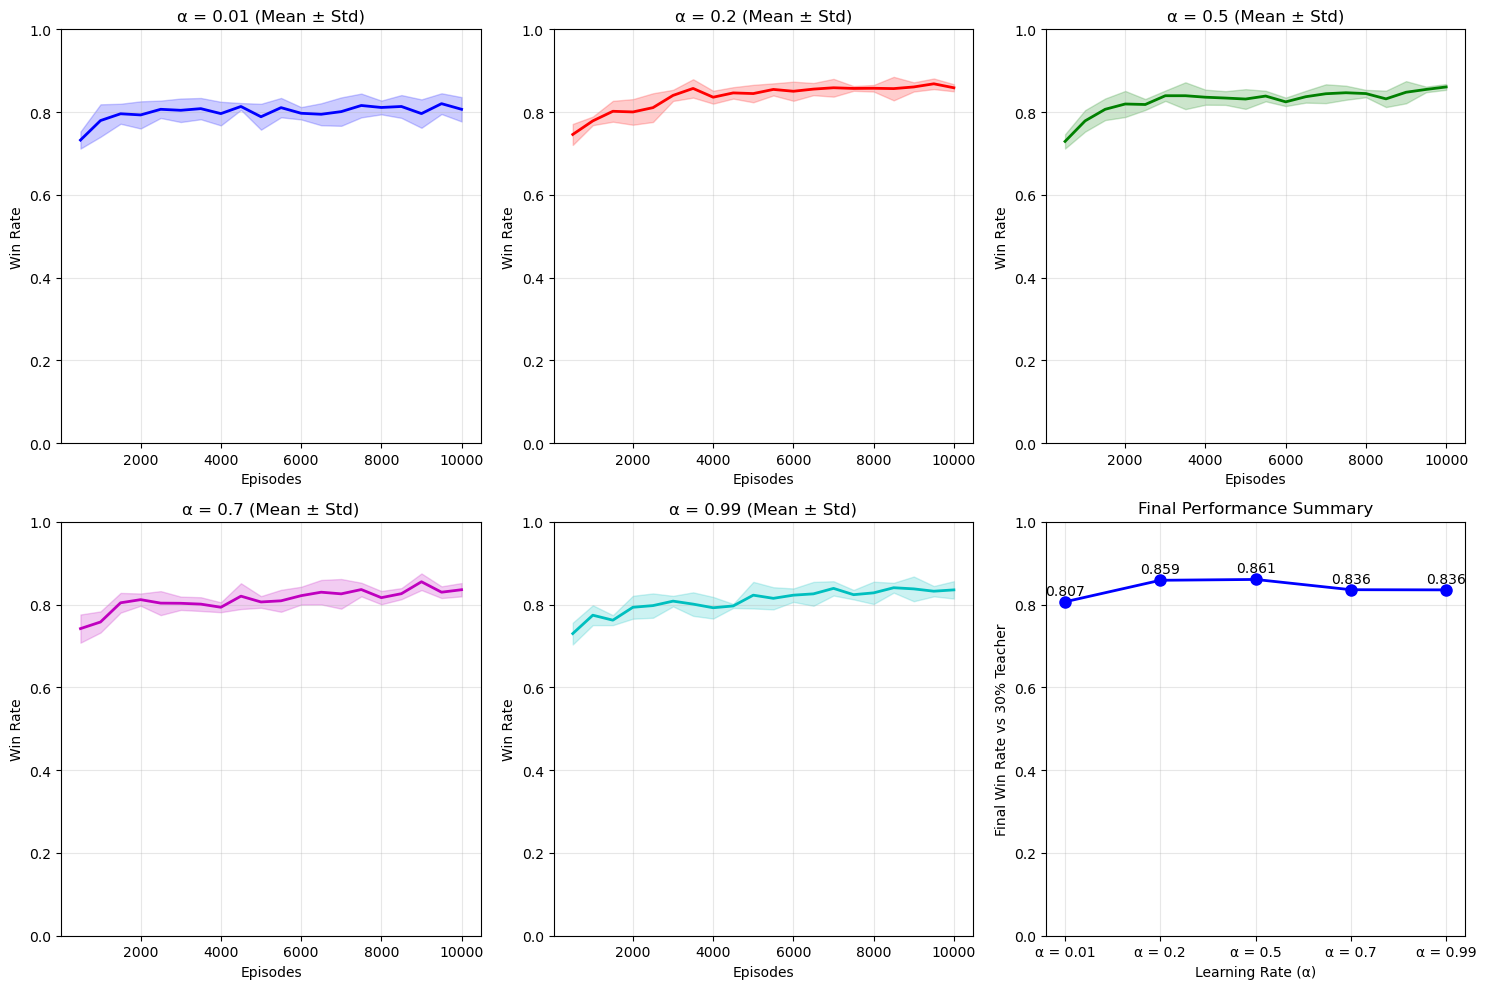


Final Performance Summary:
----------------------------------------------------------------------
α = 0.01: Win = 0.807, Loss = 0.079, Draw = 0.114
α = 0.20: Win = 0.859, Loss = 0.040, Draw = 0.101
α = 0.50: Win = 0.861, Loss = 0.043, Draw = 0.096
α = 0.70: Win = 0.836, Loss = 0.047, Draw = 0.117
α = 0.99: Win = 0.836, Loss = 0.060, Draw = 0.104
\nBest performing agent: α = 0.5 (Win rate: 0.861)


In [ ]:
import random
import csv
import matplotlib.pyplot as plt

# Game constants
EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3

BOARD_FORMAT = "----------------------------\n| {0} | {1} | {2} |\n|--------------------------|\n| {3} | {4} | {5} |\n|--------------------------|\n| {6} | {7} | {8} |\n----------------------------"
NAMES = [' ', 'X', 'O']

def printboard(state):
    cells = []
    for i in range(3):
        for j in range(3):
            cells.append(NAMES[state[i][j]].center(6))
    print(BOARD_FORMAT.format(*cells))

def emptystate():
    return [[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]]

def gameover(state):
    # Check rows
    for i in range(3):
        if state[i][0] != EMPTY and state[i][0] == state[i][1] and state[i][0] == state[i][2]:
            return state[i][0]
    # Check columns
    for i in range(3):
        if state[0][i] != EMPTY and state[0][i] == state[1][i] and state[0][i] == state[2][i]:
            return state[0][i]
    # Check diagonals
    if state[0][0] != EMPTY and state[0][0] == state[1][1] and state[0][0] == state[2][2]:
        return state[0][0]
    if state[0][2] != EMPTY and state[0][2] == state[1][1] and state[0][2] == state[2][0]:
        return state[0][2]
    # Check for draw
    for i in range(3):
        for j in range(3):
            if state[i][j] == EMPTY:
                return EMPTY
    return DRAW

def last_to_act(state):
    countx = 0
    counto = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] == PLAYER_X:
                countx += 1
            elif state[i][j] == PLAYER_O:
                counto += 1
    if countx == counto:
        return PLAYER_O
    if countx == (counto + 1):
        return PLAYER_X
    return -1

def enumstates(state, idx, agent):
    if idx > 8:
        player = last_to_act(state)
        if player == agent.player:
            agent.add(state)
    else:
        winner = gameover(state)
        if winner != EMPTY:
            return
        i = int(idx / 3)
        j = int(idx % 3)
        for val in range(3):
            state[i][j] = val
            enumstates(state, idx+1, agent)

class Agent(object):
    def __init__(self, player, verbose=False, lossval=-1, learning=True, alpha=0.1):
        self.values = {}
        self.player = player
        self.verbose = verbose
        self.lossval = lossval
        self.learning = learning
        self.epsilon = 0.1
        self.alpha = alpha
        self.prevstate = None
        self.prevscore = 0
        self.count = 0
        enumstates(emptystate(), 0, self)

    def episode_over(self, winner):
        self.backup(self.winnerval(winner))
        self.prevstate = None
        self.prevscore = 0

    def action(self, state):
        r = random.random()
        if r < self.epsilon:
            move = self.random(state)
            self.log('>>>>>>> Exploratory action: ' + str(move))
        else:
            move = self.greedy(state)
            self.log('>>>>>>> Best action: ' + str(move))
        state[move[0]][move[1]] = self.player
        self.prevstate = self.statetuple(state)
        self.prevscore = self.lookup(state)
        state[move[0]][move[1]] = EMPTY
        return move

    def random(self, state):
        available = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    available.append((i,j))
        return random.choice(available)

    def greedy(self, state):
        maxval = -50000
        maxmove = None
        if self.verbose:
            cells = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup(state)
                    state[i][j] = EMPTY
                    if val > maxval:
                        maxval = val
                        maxmove = (i, j)
                    if self.verbose:
                        cells.append('{0:.3f}'.format(val).center(6))
                elif self.verbose:
                    cells.append(NAMES[state[i][j]].center(6))
        if self.verbose:
            print(BOARD_FORMAT.format(*cells))
        self.backup(maxval)
        return maxmove

    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        elif winner == DRAW:
            return 0
        else:
            return self.lossval

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

    def log(self, s):
        if self.verbose:
            print(s)

class Human(object):
    def __init__(self, player):
        self.player = player

    def action(self, state):
        printboard(state)
        while True:
            try:
                action = input('Your move? i.e. x,y : ')
                row, col = int(action.split(',')[0]), int(action.split(',')[1])
                if 0 <= row <= 2 and 0 <= col <= 2:
                    if state[row][col] == EMPTY:
                        return (row, col)
                    else:
                        print("That position is already occupied! Please choose an empty square.")
                else:
                    print("Please enter coordinates between 0-2 (e.g., 1,1)")
            except (ValueError, IndexError):
                print("Invalid input! Please enter in format: x,y (e.g., 1,1)")

    def episode_over(self, winner):
        if winner == DRAW:
            print('Game over! It was a draw.')
        else:
            print('Game over! Winner: Player {0}'.format(winner))

class Teacher:
    def __init__(self, level=0.9, player=PLAYER_O, learning=True, alpha=0.99):
        self.ability_level = level
        self.player = player
        # Add RL learning capabilities to teacher
        self.learning = learning
        self.alpha = alpha
        self.values = {}
        self.prevstate = None
        self.prevscore = 0
        self.lossval = -1
        # Initialize value function for all possible states
        enumstates(emptystate(), 0, self)

    def convert_board(self, state):
        """Convert from numeric board to string board for teacher logic"""
        board = []
        for i in range(3):
            row = []
            for j in range(3):
                if state[i][j] == EMPTY:
                    row.append('-')
                elif state[i][j] == PLAYER_X:
                    row.append('X')
                else:
                    row.append('O')
            board.append(row)
        return board

    def win(self, board, key='O'):
        """If we have two in a row and the 3rd is available, take it."""
        # Check for diagonal wins
        a = [board[0][0], board[1][1], board[2][2]]
        b = [board[0][2], board[1][1], board[2][0]]
        if a.count('-') == 1 and a.count(key) == 2:
            ind = a.index('-')
            return ind, ind
        elif b.count('-') == 1 and b.count(key) == 2:
            ind = b.index('-')
            if ind == 0:
                return 0, 2
            elif ind == 1:
                return 1, 1
            else:
                return 2, 0
        # Now check for 2 in a row/column + empty 3rd
        for i in range(3):
            c = [board[0][i], board[1][i], board[2][i]]
            d = [board[i][0], board[i][1], board[i][2]]
            if c.count('-') == 1 and c.count(key) == 2:
                ind = c.index('-')
                return ind, i
            elif d.count('-') == 1 and d.count(key) == 2:
                ind = d.index('-')
                return i, ind
        return None

    def blockWin(self, board):
        """Block the opponent if she has a win available."""
        return self.win(board, key='X')

    def fork(self, board):
        """Create a fork opportunity such that we have 2 threats to win."""
        # Check all adjacent side middles
        if board[1][0] == 'O' and board[0][1] == 'O':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'O' and board[2][1] == 'O':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'O' and board[1][2] == 'O':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'O' and board[0][1] == 'O':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        # Check all cross corners
        elif board[0][0] == 'O' and board[2][2] == 'O':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'O' and board[0][2] == 'O':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def blockFork(self, board):
        """Block the opponents fork if she has one available."""
        corners = [board[0][0], board[2][0], board[0][2], board[2][2]]
        # Check all adjacent side middles
        if board[1][0] == 'X' and board[0][1] == 'X':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'X' and board[2][1] == 'X':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'X' and board[1][2] == 'X':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'X' and board[0][1] == 'X':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        # Check all cross corners (first check for double fork opp using the corners array)
        elif corners.count('-') == 1 and corners.count('X') == 2:
            return 1, 2
        elif board[0][0] == 'X' and board[2][2] == 'X':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'X' and board[0][2] == 'X':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def center(self, board):
        """Pick the center if it is available."""
        if board[1][1] == '-':
            return 1, 1
        return None

    def corner(self, board):
        """Pick a corner move."""
        # Pick opposite corner of opponent if available
        if board[0][0] == 'X' and board[2][2] == '-':
            return 2, 2
        elif board[2][0] == 'X' and board[0][2] == '-':
            return 0, 2
        elif board[0][2] == 'X' and board[2][0] == '-':
            return 2, 0
        elif board[2][2] == 'X' and board[0][0] == '-':
            return 0, 0
        # Pick any corner if no opposites are available
        elif board[0][0] == '-':
            return 0, 0
        elif board[2][0] == '-':
            return 2, 0
        elif board[0][2] == '-':
            return 0, 2
        elif board[2][2] == '-':
            return 2, 2
        return None

    def sideEmpty(self, board):
        """Pick an empty side."""
        if board[1][0] == '-':
            return 1, 0
        elif board[2][1] == '-':
            return 2, 1
        elif board[1][2] == '-':
            return 1, 2
        elif board[0][1] == '-':
            return 0, 1
        return None

    def randomMove(self, board):
        """Choose a random move from the available options."""
        possibles = []
        for i in range(3):
            for j in range(3):
                if board[i][j] == '-':
                    possibles += [(i, j)]
        return possibles[random.randint(0, len(possibles)-1)]

    def makeMove(self, board):
        """
        Teacher goes through a hierarchy of moves, making the best move that
        is currently available each time. A tuple is returned that represents
        (row, col).
        """
        # Choose randomly with some probability so that the teacher does not always win
        if random.random() > self.ability_level:
            return self.randomMove(board)
        # Follow optimal strategy
        a = self.win(board)
        if a is not None:
            return a
        a = self.blockWin(board)
        if a is not None:
            return a
        a = self.fork(board)
        if a is not None:
            return a
        a = self.blockFork(board)
        if a is not None:
            return a
        a = self.center(board)
        if a is not None:
            return a
        a = self.corner(board)
        if a is not None:
            return a
        a = self.sideEmpty(board)
        if a is not None:
            return a
        return self.randomMove(board)

    def action(self, state):
        """Convert state and make move using teacher logic with RL learning"""
        board = self.convert_board(state)
        move = self.makeMove(board)
        
        # Add RL learning like Agent class
        if self.learning:
            state[move[0]][move[1]] = self.player
            self.prevstate = self.statetuple(state)
            self.prevscore = self.lookup(state)
            state[move[0]][move[1]] = EMPTY
        
        return move

    def episode_over(self, winner):
        """Learn from game outcome like Agent class"""
        if self.learning:
            self.backup(self.winnerval(winner))
            self.prevstate = None
            self.prevscore = 0

    # Add RL learning methods to Teacher (same as Agent)
    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        elif winner == DRAW:
            return 0
        else:
            return self.lossval

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

def play(agent1, agent2):
    """Play a single game between two agents"""
    state = emptystate()
    for i in range(9):
        if i % 2 == 0:
            move = agent1.action(state)
        else:
            move = agent2.action(state)
        state[move[0]][move[1]] = (i % 2) + 1
        winner = gameover(state)
        if winner != EMPTY:
            return winner
    return winner

def measure_performance_vs_opponent(agent, opponent, games=100):
    """Measure agent performance against any opponent (no learning)"""
    original_epsilon = agent.epsilon
    original_learning = agent.learning
    agent.epsilon = 0  # Pure greedy
    agent.learning = False
    
    wins = 0
    losses = 0
    draws = 0
    
    for _ in range(games):
        winner = play(agent, opponent)
        if winner == agent.player:
            wins += 1
        elif winner == opponent.player:
            losses += 1
        else:
            draws += 1
    
    # Restore original settings
    agent.epsilon = original_epsilon
    agent.learning = original_learning
    
    return wins / games, losses / games, draws / games

def run_multiple_experiments(alpha_values, total_episodes=5000, eval_interval=100, num_runs=5):
    """Run multiple independent experiments and average results"""
    all_runs = {}
    individual_results = {}
    
    for run in range(num_runs):
        print(f"Running experiment set {run + 1}/{num_runs}")
        # Use None for random seed each run, or use time-based seed for true randomness
        results, _ = run_single_experiment(alpha_values, total_episodes, eval_interval, None)
        all_runs[run] = results
        
        # Store individual run results
        for alpha in alpha_values:
            if alpha not in individual_results:
                individual_results[alpha] = []
            final_win_rate = results[alpha]['win_rates'][-1]
            individual_results[alpha].append(final_win_rate)
            print(f"  Run {run + 1}: α = {alpha} → {final_win_rate:.3f} win rate")
    
    # Average across runs
    averaged_results = {}
    trained_agents = {}
    
    for alpha in alpha_values:
        # Collect all episodes and rates from all runs
        all_episodes = all_runs[0][alpha]['episodes']
        all_win_rates = []
        all_loss_rates = []
        all_draw_rates = []
        
        for run in range(num_runs):
            all_win_rates.append(all_runs[run][alpha]['win_rates'])
            all_loss_rates.append(all_runs[run][alpha]['loss_rates'])
            all_draw_rates.append(all_runs[run][alpha]['draw_rates'])
        
        # Calculate mean and std for each evaluation point
        import numpy as np
        mean_win_rates = np.mean(all_win_rates, axis=0)
        std_win_rates = np.std(all_win_rates, axis=0)
        mean_loss_rates = np.mean(all_loss_rates, axis=0)
        std_loss_rates = np.std(all_loss_rates, axis=0)
        mean_draw_rates = np.mean(all_draw_rates, axis=0)
        std_draw_rates = np.std(all_draw_rates, axis=0)
        
        averaged_results[alpha] = {
            'episodes': all_episodes,
            'win_rates': mean_win_rates,
            'win_std': std_win_rates,
            'loss_rates': mean_loss_rates,
            'loss_std': std_loss_rates,
            'draw_rates': mean_draw_rates,
            'draw_std': std_draw_rates
        }
        
        # Train one final agent for human play
        print(f"Training final agent for human play with alpha = {alpha}")
        agent = Agent(PLAYER_X, alpha=alpha, lossval=-1)
        teacher = Teacher(level=0.3, player=PLAYER_O, learning=False)  # 30% optimal for exploratory training
        for _ in range(total_episodes):
            winner = play(agent, teacher)
            agent.episode_over(winner)
        trained_agents[alpha] = agent
    
    # Print detailed results summary
    print("\n" + "="*80)
    print("DETAILED RESULTS SUMMARY")
    print("="*80)
    
    for alpha in alpha_values:
        runs = individual_results[alpha]
        mean_val = np.mean(runs)
        std_val = np.std(runs)
        print(f"\nα = {alpha}:")
        print(f"  Individual runs: {[f'{x:.3f}' for x in runs]}")
        print(f"  Mean: {mean_val:.3f}")
        print(f"  Std Dev: {std_val:.3f}")
        print(f"  Range: {min(runs):.3f} - {max(runs):.3f}")
    
    return averaged_results, trained_agents

def run_single_experiment(alpha_values, total_episodes=5000, eval_interval=100, seed=None):
    """Run single learning experiment with optional random seed"""
    if seed is not None:
        random.seed(seed)
    
    results = {}
    trained_agents = {}
    
    for alpha in alpha_values:
        print(f"  Alpha = {alpha}")
        
        # Create agent and exploratory teacher for diverse training
        agent = Agent(PLAYER_X, alpha=alpha, lossval=-1)
        teacher = Teacher(level=0.3, player=PLAYER_O, learning=False)  # 30% optimal = more exploratory
        
        # Track training results
        training_results = []
        episode_points = []
        win_rates = []
        loss_rates = []
        draw_rates = []
        
        for episode in range(1, total_episodes + 1):
            winner = play(agent, teacher)
            agent.episode_over(winner)
            
            if winner == agent.player:
                training_results.append('win')
            elif winner == teacher.player:
                training_results.append('loss')
            else:
                training_results.append('draw')
            
            if episode % eval_interval == 0:
                recent_results = training_results[-eval_interval:]
                wins = recent_results.count('win')
                losses = recent_results.count('loss')
                draws = recent_results.count('draw')
                
                win_rate = wins / len(recent_results)
                loss_rate = losses / len(recent_results)
                draw_rate = draws / len(recent_results)
                
                episode_points.append(episode)
                win_rates.append(win_rate)
                loss_rates.append(loss_rate)
                draw_rates.append(draw_rate)
        
        results[alpha] = {
            'episodes': episode_points,
            'win_rates': win_rates,
            'loss_rates': loss_rates,
            'draw_rates': draw_rates
        }
        
        trained_agents[alpha] = agent
    
    return results, trained_agents

def plot_learning_curves_with_error_bars(results):
    """Plot learning curves with error bars from multiple runs"""
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    
    # Create two separate figures for clarity
    # Figure 1: Main comparison with error bars
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.errorbar(data['episodes'], data['win_rates'], 
                    yerr=data['win_std'],
                    color=colors[i % len(colors)], 
                    marker='o', 
                    label=f'α = {alpha}',
                    linewidth=2,
                    markersize=4,
                    capsize=3)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Win Rate vs 30% Optimal Teacher')
    plt.title('RL Agent Performance: Mean ± Std Dev (5 independent runs)\nTraining Against Exploratory 30% Optimal Teacher')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Figure 2: Individual alpha plots with final performance summary
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Individual alpha plots
    for i, (alpha, data) in enumerate(results.items()):
        if i < 5:  # First 5 subplots for individual alphas
            axes[i].plot(data['episodes'], data['win_rates'], 
                        color=colors[i % len(colors)], 
                        linewidth=2)
            axes[i].fill_between(data['episodes'], 
                                data['win_rates'] - data['win_std'],
                                data['win_rates'] + data['win_std'],
                                color=colors[i % len(colors)], alpha=0.2)
            axes[i].set_xlabel('Episodes')
            axes[i].set_ylabel('Win Rate')
            axes[i].set_title(f'α = {alpha} (Mean ± Std)')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim(0, 1)
    
    # Final performance summary in the 6th subplot
    alphas = list(results.keys())
    final_win_rates = [results[alpha]['win_rates'][-1] for alpha in alphas]
    
    axes[5].plot(range(len(alphas)), final_win_rates, 
                 marker='o', 
                 linewidth=2,
                 markersize=8,
                 color='blue')
    
    # Add value labels on points
    for i, win_rate in enumerate(final_win_rates):
        axes[5].text(i, win_rate + 0.01,
                    f'{win_rate:.3f}',
                    ha='center', va='bottom', fontsize=10)
    
    axes[5].set_xlabel('Learning Rate (α)')
    axes[5].set_ylabel('Final Win Rate vs 30% Teacher')
    axes[5].set_title('Final Performance Summary')
    axes[5].set_xticks(range(len(alphas)))
    axes[5].set_xticklabels([f'α = {alpha}' for alpha in alphas])
    axes[5].set_ylim(0, 1)
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()

def plot_final_performance_summary(results):
    """Plot final performance summary as bar chart"""
    plt.figure(figsize=(10, 6))
    
    alphas = list(results.keys())
    final_win_rates = [results[alpha]['win_rates'][-1] for alpha in alphas]
    final_win_stds = [results[alpha]['win_std'][-1] for alpha in alphas]
    
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    
    plt.plot(range(len(alphas)), final_win_rates, 
             marker='o', 
             linewidth=2,
             markersize=8,
             color='blue')
    
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Final Win Rate vs 30% Optimal Teacher')
    plt.title('Final Performance Summary After 10,000 Training Episodes\n(Mean ± Std Dev from 5 independent runs)')
    plt.xticks(range(len(alphas)), [f'α = {alpha}' for alpha in alphas])
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on points
    for i, win_rate in enumerate(final_win_rates):
        plt.text(i, win_rate + 0.01,
                f'{win_rate:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()

def plot_performance_breakdown(results):
    """Plot win/loss/draw rates separately for different alpha values as individual graphs"""
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    
    # Plot win rates
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.plot(data['episodes'], data['win_rates'], 
                color=colors[i % len(colors)], 
                marker='o', 
                label=f'α = {alpha}',
                linewidth=2,
                markersize=4)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Win Rate')
    plt.title('Win Rate vs Random Agent over Training Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(100, max([max(data['episodes']) for data in results.values()]))
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Plot loss rates
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.plot(data['episodes'], data['loss_rates'], 
                color=colors[i % len(colors)], 
                marker='s', 
                label=f'α = {alpha}',
                linewidth=2,
                markersize=4)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Loss Rate')
    plt.title('Loss Rate vs Random Agent over Training Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(100, max([max(data['episodes']) for data in results.values()]))
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Plot draw rates
    plt.figure(figsize=(12, 8))
    for i, (alpha, data) in enumerate(results.items()):
        plt.plot(data['episodes'], data['draw_rates'], 
                color=colors[i % len(colors)], 
                marker='^', 
                label=f'α = {alpha}',
                linewidth=2,
                markersize=4)
    
    plt.xlabel('Training Episodes')
    plt.ylabel('Draw Rate')
    plt.title('Draw Rate vs Random Agent over Training Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(100, max([max(data['episodes']) for data in results.values()]))
    plt.ylim(0, 1)
    plt.tight_layout()

def plot_individual_alpha_performance(results):
    """Plot all alpha values and summary in one landscape figure"""
    alpha_values = list(results.keys())
    
    # Create landscape figure with subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('RL Agent Performance by Learning Rate (α)\nWinning rate per 500 episodes (10,000 total episodes) vs 90% Optimal Teacher', fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Plot individual alpha performance in first 5 subplots
    for i, (alpha, data) in enumerate(results.items()):
        ax = axes[i]
        
        ax.plot(data['episodes'], data['win_rates'], 
                color='red', linewidth=2, label='Win Rate')
        ax.plot(data['episodes'], data['loss_rates'], 
                color='blue', linewidth=2, label='Loss Rate')
        ax.plot(data['episodes'], data['draw_rates'], 
                color='green', linewidth=2, label='Draw Rate')
        
        ax.set_xlabel('Training Episodes')
        ax.set_ylabel('Rate')
        ax.set_title(f'α = {alpha}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(500, max(data['episodes']))
        ax.set_ylim(0, 1)
    
    # Add final performance comparison in the 6th subplot
    ax_final = axes[5]
    
    # Extract final performance data
    final_win_rates = [results[alpha]['win_rates'][-1] for alpha in alpha_values]
    final_loss_rates = [results[alpha]['loss_rates'][-1] for alpha in alpha_values]
    final_draw_rates = [results[alpha]['draw_rates'][-1] for alpha in alpha_values]
    
    ax_final.plot(alpha_values, final_win_rates, marker='o', linewidth=2, markersize=8, label='Win Rate', color='red')
    ax_final.plot(alpha_values, final_loss_rates, marker='s', linewidth=2, markersize=8, label='Loss Rate', color='blue')
    ax_final.plot(alpha_values, final_draw_rates, marker='^', linewidth=2, markersize=8, label='Draw Rate', color='green')
    
    # Add value labels on points
    for i, alpha in enumerate(alpha_values):
        ax_final.annotate(f'{final_win_rates[i]:.2f}', (alpha, final_win_rates[i]), 
                         textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    ax_final.set_xlabel('Learning Rate (α)')
    ax_final.set_ylabel('Final Rate')
    ax_final.set_title('Final Performance Summary')
    ax_final.legend()
    ax_final.grid(True, alpha=0.3)
    ax_final.set_ylim(0, 1)
    ax_final.set_xlim(min(alpha_values) - 0.05, max(alpha_values) + 0.05)
    
    plt.tight_layout()
    plt.savefig('all_alpha_performance_complete.png', dpi=300, bbox_inches='tight')
    print("Complete performance analysis saved to: all_alpha_performance_complete.png")

def plot_final_performance_by_alpha(results):
    """Plot final win/loss/draw rates for each alpha value as line chart"""
    alpha_values = list(results.keys())
    win_rates = [results[alpha]['win_rates'][-1] for alpha in alpha_values]
    loss_rates = [results[alpha]['loss_rates'][-1] for alpha in alpha_values]
    draw_rates = [results[alpha]['draw_rates'][-1] for alpha in alpha_values]
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(alpha_values, win_rates, marker='o', linewidth=2, markersize=8, label='Win Rate', color='green')
    plt.plot(alpha_values, loss_rates, marker='s', linewidth=2, markersize=8, label='Loss Rate', color='red')
    plt.plot(alpha_values, draw_rates, marker='^', linewidth=2, markersize=8, label='Draw Rate', color='blue')
    
    # Add value labels on points
    for i, alpha in enumerate(alpha_values):
        plt.annotate(f'{win_rates[i]:.3f}', (alpha, win_rates[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f'{loss_rates[i]:.3f}', (alpha, loss_rates[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f'{draw_rates[i]:.3f}', (alpha, draw_rates[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Rate')
    plt.title('Final Performance by Learning Rate\n(After 10000 Training Episodes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.xlim(min(alpha_values) - 0.05, max(alpha_values) + 0.05)
    
    plt.tight_layout()
    plt.savefig('final_performance_by_alpha.png', dpi=300, bbox_inches='tight')
    print("Final performance comparison saved to: final_performance_by_alpha.png")

def play_human_vs_agent(agent):
    """Allow human to play against the trained agent with value visualization"""
    print("\n" + "="*50)
    print("PLAY AGAINST THE TRAINED AGENT!")
    print("="*50)
    print("Enter your moves as x,y coordinates (0,1,2)")
    print("Example: 1,1 for center, 0,0 for top-left")
    print("Values shown are agent's learned position evaluations")
    print("="*50)
    
    # Set agent to pure greedy and verbose
    agent.epsilon = 0
    agent.learning = False
    agent.verbose = True  # Enable value display
    
    human = Human(PLAYER_O)
    
    while True:
        print(f"\nStarting new game! Agent is X, You are O")
        winner = play(agent, human)
        
        if winner == PLAYER_X:
            print("Agent wins! Better luck next time.")
        elif winner == PLAYER_O:
            print("Congratulations! You won!")
        else:
            print("It's a draw!")
        
        play_again = input("\nWant to play again? (y/n): ").lower().strip()
        if play_again != 'y' and play_again != 'yes':
            break
    
    print("Thanks for playing!")

if __name__ == "__main__":
    # Test different learning rates - Report requirement
    alpha_values = [0.01, 0.2, 0.5, 0.7, 0.99]

    print("Starting learning rate comparison experiment...")
    print("Observing effect of learning rate (α) on winning rate...")
    print("This will take several minutes to complete.")
    
    # Run multiple experiments with averaging (5 runs for statistical reliability)
    results, trained_agents = run_multiple_experiments(alpha_values, total_episodes=10000, eval_interval=500, num_runs=5)
    
    # Plot results with error bars showing variability
    plot_learning_curves_with_error_bars(results)
    
    # Show all plots at once
    plt.show()
    
    # Save detailed results to CSV
    with open('learning_rate_results.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        
        # Write header
        header = ['Episode']
        for alpha in alpha_values:
            header.extend([f'Alpha_{alpha}_WinRate', f'Alpha_{alpha}_LossRate', f'Alpha_{alpha}_DrawRate'])
        writer.writerow(header)
        
        # Write data
        max_episodes = max(len(data['episodes']) for data in results.values())
        for i in range(max_episodes):
            row = []
            episode = None
            for alpha in alpha_values:
                if i < len(results[alpha]['episodes']):
                    if episode is None:
                        episode = results[alpha]['episodes'][i]
                    row.extend([results[alpha]['win_rates'][i], 
                               results[alpha]['loss_rates'][i], 
                               results[alpha]['draw_rates'][i]])
                else:
                    row.extend(['', '', ''])
            if episode is not None:
                writer.writerow([episode] + row)
    
    # print("Detailed results saved to: learning_rate_results.csv")
    
    # Print final performance summary
    print("\nFinal Performance Summary:")
    print("-" * 70)
    for alpha in alpha_values:
        final_win_rate = results[alpha]['win_rates'][-1]
        final_loss_rate = results[alpha]['loss_rates'][-1]
        final_draw_rate = results[alpha]['draw_rates'][-1]
        print(f"α = {alpha:4.2f}: Win = {final_win_rate:.3f}, Loss = {final_loss_rate:.3f}, Draw = {final_draw_rate:.3f}")
    
    # Ask user if they want to play against the best performing agent
    best_alpha = max(alpha_values, key=lambda a: results[a]['win_rates'][-1])
    print(f"\\nBest performing agent: α = {best_alpha} (Win rate: {results[best_alpha]['win_rates'][-1]:.3f})")
    
    play_choice = input("\\nWould you like to play against an opponent? (y/n): ").lower().strip()
    if play_choice == 'y' or play_choice == 'yes':
        opponent_choice = input("Choose opponent: (1) Trained RL Agent (2) Optimal Teacher: ").strip()
        
        if opponent_choice == "2":
            # Play against the optimal teacher
            print("Setting up optimal teacher opponent...")
            teacher_opponent = Teacher(level=1.0, player=PLAYER_O)  # 100% optimal
            play_human_vs_agent(teacher_opponent)
        else:
            # Let user choose alpha value from the experiment
            print("\\nChoose alpha value for the RL agent:")
            print("Available alpha values from experiment:", alpha_values)
            while True:
                try:
                    chosen_alpha = float(input("Enter alpha value: "))
                    if chosen_alpha in alpha_values:
                        break
                    else:
                        print(f"Please choose from: {alpha_values}")
                except ValueError:
                    print("Please enter a valid number.")
            
            # Reuse the already trained agent from the experiment
            print(f"Using already trained RL agent with α={chosen_alpha}...")
            human_play_agent = trained_agents[chosen_alpha]
            
            # Keep agent as PLAYER_X (same as training) to preserve learned values
            
            print(f"Agent ready for human play (already trained for {10000} episodes)!")
            play_human_vs_agent(human_play_agent)